In [1]:
#import multiprocessing
import LibAu as la
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import h5py as h5
import warnings
warnings.filterwarnings('ignore')

In [2]:
la.L3MHDsam

[16, 21, 23, 24, 27, 6]

Au-16
/virgo/simulations/Auriga/level3_MHD/halo_16/output/
DM particles:  30330070 30334251


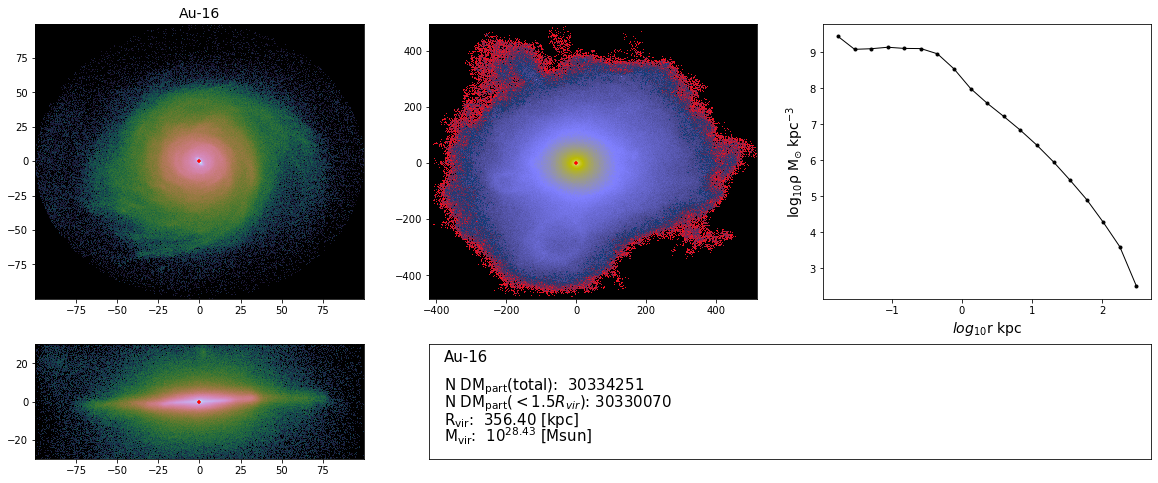

Au-21
/virgo/simulations/Auriga/level3_MHD/halo_21/output/
DM particles:  30957677 31503466


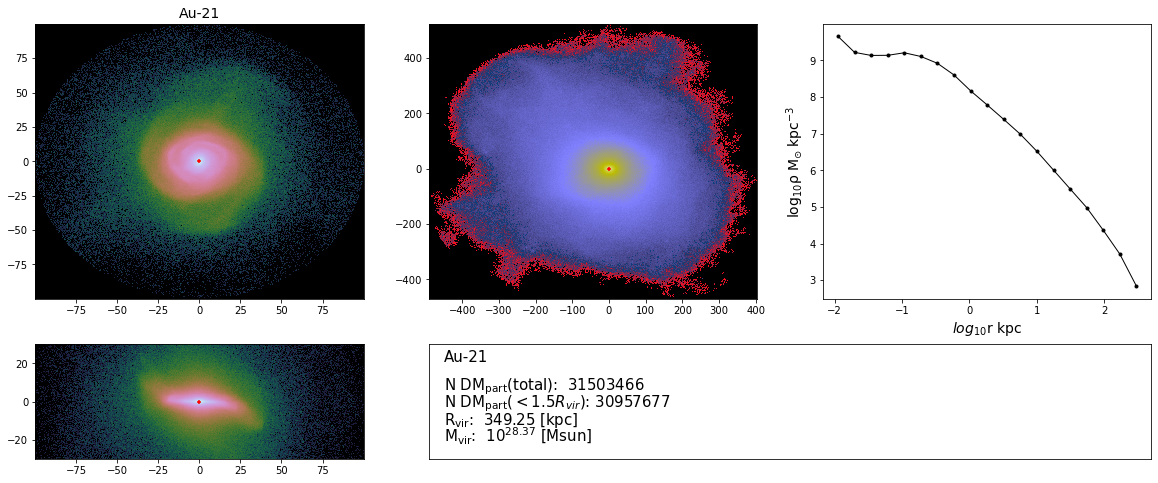

Au-23
/virgo/simulations/Auriga/level3_MHD/halo_23/output/
DM particles:  31586711 31618420


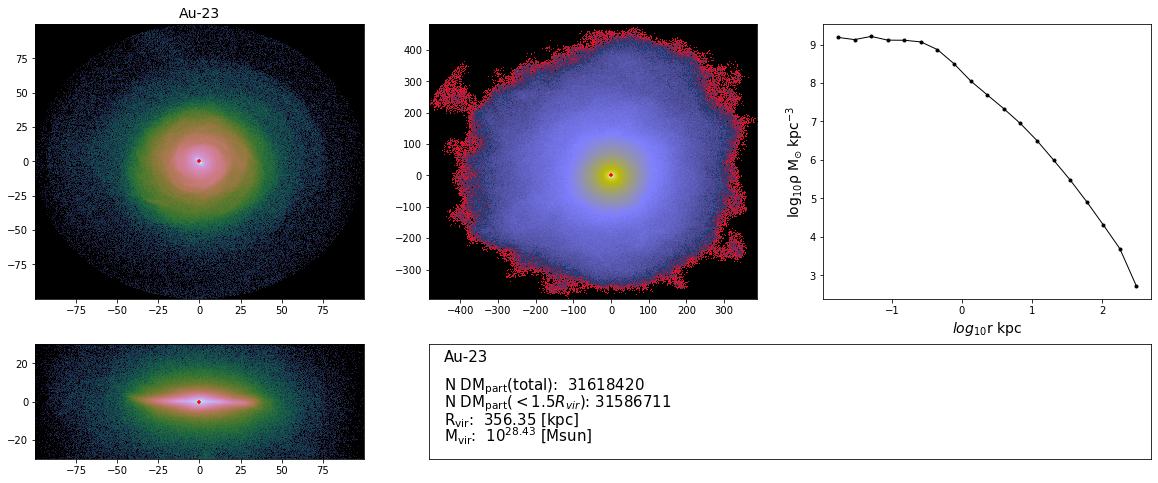

Au-24
/virgo/simulations/Auriga/level3_MHD/halo_24/output/
DM particles:  33555427 35153394


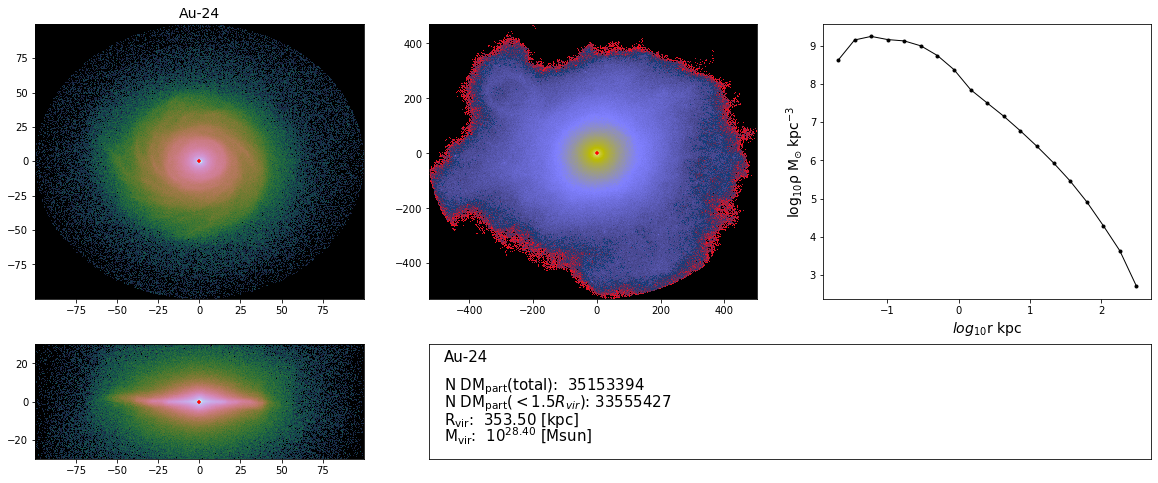

Au-27
/virgo/simulations/Auriga/level3_MHD/halo_27/output/


In [ ]:
for nhalo in la.L3MHDsam:
    
    print('Au-%s'%nhalo)
    nsnap= 63
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap)
    print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    #def func1(st,f): return sim.Snapshot_Subhalo(idSubhalo=0,snapType=st,fields=f)
    fields_stars = ['pos','vel','id','mass','type','pot','age']
    fields_dm = ['pos','vel','id','mass','type','pot']
    #manager = multiprocessing.Manager()
    #return_dict = manager.dict()
    
    #p1 = multiprocessing.Process(target=func1, args=('stars',fields_stars))
    #p2 = multiprocessing.Process(target=func1, args=('dm1',fields_dm))
    #p1.start()
    #p2.start()
    #p1.join()
    #p2.join()
    Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
    #print(return_dict.values())
    #break
    #del p1,p2
    
    Data = {'stars':Datstars,'dm1':DatDM}
    param = {'spos':sim.sf.data['spos'][0,:],
            'svel':sim.sf.data['svel'][0,:],
            'header':sim.Header()}
    
    gal = la.ToolRot(Data=Data, param=param)
    Data = gal.Rotate()
    Datstars=Data['stars']
    DatDM = Data['dm1']
    
    
    # Stellar Parameter -------------------------------
    poss = Datstars['pos']#[kpc]
    Xs = poss[:,0] 
    Ys = poss[:,1]
    Zs = poss[:,2]
    Ms = Datstars['mass'] #[Msun]
    
    rs = np.sqrt(Xs**2 + Ys**2)
    
    # DM paramater ------------------------------------
    posdm = DatDM['pos'] #[kpc
    Xdm = posdm[:,0]
    Ydm = posdm[:,1]
    Zdm = posdm[:,2]
    Mdm = DatDM['mass'] #[Msun]
    r3dm = np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    Npartbe = len(r3dm)
    # --------------------------------------------------
    
    cuts= (rs<=100)& (np.abs(Zs)<=30)
    Xs,Ys,Zs,Ms=Xs[cuts],Ys[cuts],Zs[cuts],Ms[cuts]
    
    cutdm= r3dm<=1.5*Rvir
    Xdm,Ydm,Zdm,Mdm,r3dm=Xdm[cutdm],Ydm[cutdm],Zdm[cutdm],Mdm[cutdm],r3dm[cutdm]
    print('DM particles: ',len(r3dm),Npartbe)
    #------------------------------------------------------------------------
    
    #SDf = lambda x,y,k,dim: la.StellarDensity2D(x,y,k,npix = dim,style='SD')
    
    #p1=multiprocessing.Process(target=SDf, args=(Xs,Ys,Ms,[720,720]))
    #p2=multiprocessing.Process(target=SDf, args=(Xs,Zs,Ms,[720,int(720/2)]))
    #p3=multiprocessing.Process(target=SDf, args=(Xdm,Ydm,Mdm,[720,720]))
    
    #p1.start()
    #p2.start()
    #p3.start()

    Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(Xs,Ys,Ms,npix = [720,720],style='SD')
    Hse,_xse,_yse,boxse = la.StellarDensity2D(Xs,Zs,Ms,npix = [720,int(720/2)],style='SD')

    Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(Xdm,Ydm,Mdm,npix = [720,720],style='SD')
    
    


    plt.figure(figsize=(20,8))
    
    ax1=plt.subplot(3,3,(1,4))
    ax1.patch.set_facecolor('black')
    extentsf = _xsf.min(),_xsf.max(),_ysf.min(),_ysf.max()
    plt.imshow(np.log10(Hsf).T,cmap='cubehelix',extent=extentsf,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')
    plt.title('Au-%s'%nhalo,fontsize=14)
    
    ax2=plt.subplot(3,3,7)
    ax2.patch.set_facecolor('black')
    extentse = _xse.min(),_xse.max(),_yse.min(),_yse.max()
    plt.imshow(np.log10(Hse).T,cmap='cubehelix',extent=extentse,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')

    ax3=plt.subplot(3,3,(2,5))
    ax3.patch.set_facecolor('black')
    extentdm = _xdm.min(),_xdm.max(),_ydm.min(),_ydm.max()
    plt.imshow(np.log10(Hdm).T,cmap='gist_stern',extent=extentdm,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=10,c='r',marker='+')
    

    plt.subplot(3,3,(3,6))
    r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
    r3dml = np.log10(r3dm)
    DR = np.linspace(r3min,r3max,20)
    DRn = 10**DR
    rho = []
    for i,j in enumerate(DR):
        if i==len(DR)-1:continue
        sel = (j<=r3dml)&(r3dml<DR[i+1])
        vol = (4/3)*np.pi*(DRn[i+1]**3 - DRn[i]**3)
        rho.append(np.sum(Mdm[sel])/vol)

    plt.plot(DR[:-1],np.log10(rho),lw=1,marker='.',c='k')
    plt.ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
    plt.xlabel(r'$log_{10}$r kpc',fontsize=14)
    #print(DR,rho)
    
    plt.subplot(3,3,(8,9))

    plt.text(0.02,0.85,'Au-%s'%nhalo,fontsize=15)
    plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%Npartbe,fontsize=15)
    plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%len(r3dm),fontsize=15)
    plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%Rvir,fontsize=15)
    plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%.2f}$ [Msun]'%np.log(Mvir),fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    plt.close()
    
    #g1 = hf.create_group('Au-%s'%nhalo)
    hf = h5.File('Table/Data_DM_Au-%s.hdf5'%nhalo,'w')
    hf.create_dataset('x'    ,data=Xdm)
    hf.create_dataset('y'    ,data=Ydm)
    hf.create_dataset('z'    ,data=Zdm)
    hf.create_dataset('m'    ,data=Mdm)
    
    hf.close()
    

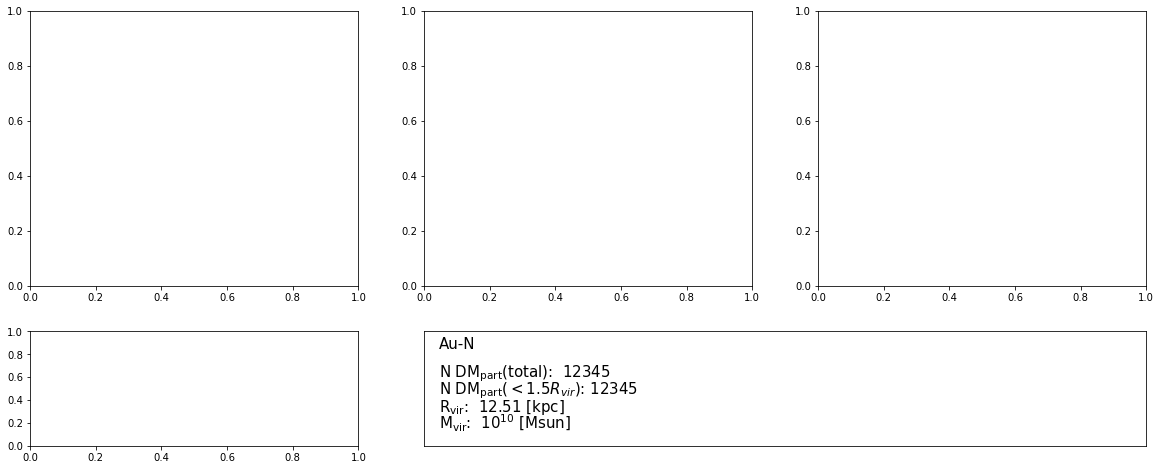

In [4]:
plt.figure(figsize=(20,8))
plt.subplot(3,3,(1,4))

plt.subplot(3,3,7)

plt.subplot(3,3,(2,5))

plt.subplot(3,3,(3,6))

plt.subplot(3,3,(8,9))

plt.text(0.02,0.85,'Au-N',fontsize=15)
plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%12345,fontsize=15)
plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%12345,fontsize=15)
plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%12.512345,fontsize=15)
plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%s}$ [Msun]'%10,fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()